>>> ADABOOST CLASSIFIER ÇALIŞTIRILIYOR...

🚀 AdaBoostClassifier Eğitiliyor...
✅ Eğitim Bitti! Süre: 10.81 saniye

🏆 ADABOOST PERFORMANS RAPORU
1. Accuracy (Doğruluk):  %70.51
2. ROC AUC Skoru:        0.6744
3. F1 Score (Weighted):  0.6000
------------------------------------------------------------
DETAYLI SINIFLANDIRMA RAPORU:
                precision    recall  f1-score   support

Çözülemedi (0)       0.54      0.04      0.07     37875
   Çözüldü (1)       0.71      0.99      0.82     89816

      accuracy                           0.71    127691
     macro avg       0.63      0.51      0.45    127691
  weighted avg       0.66      0.71      0.60    127691



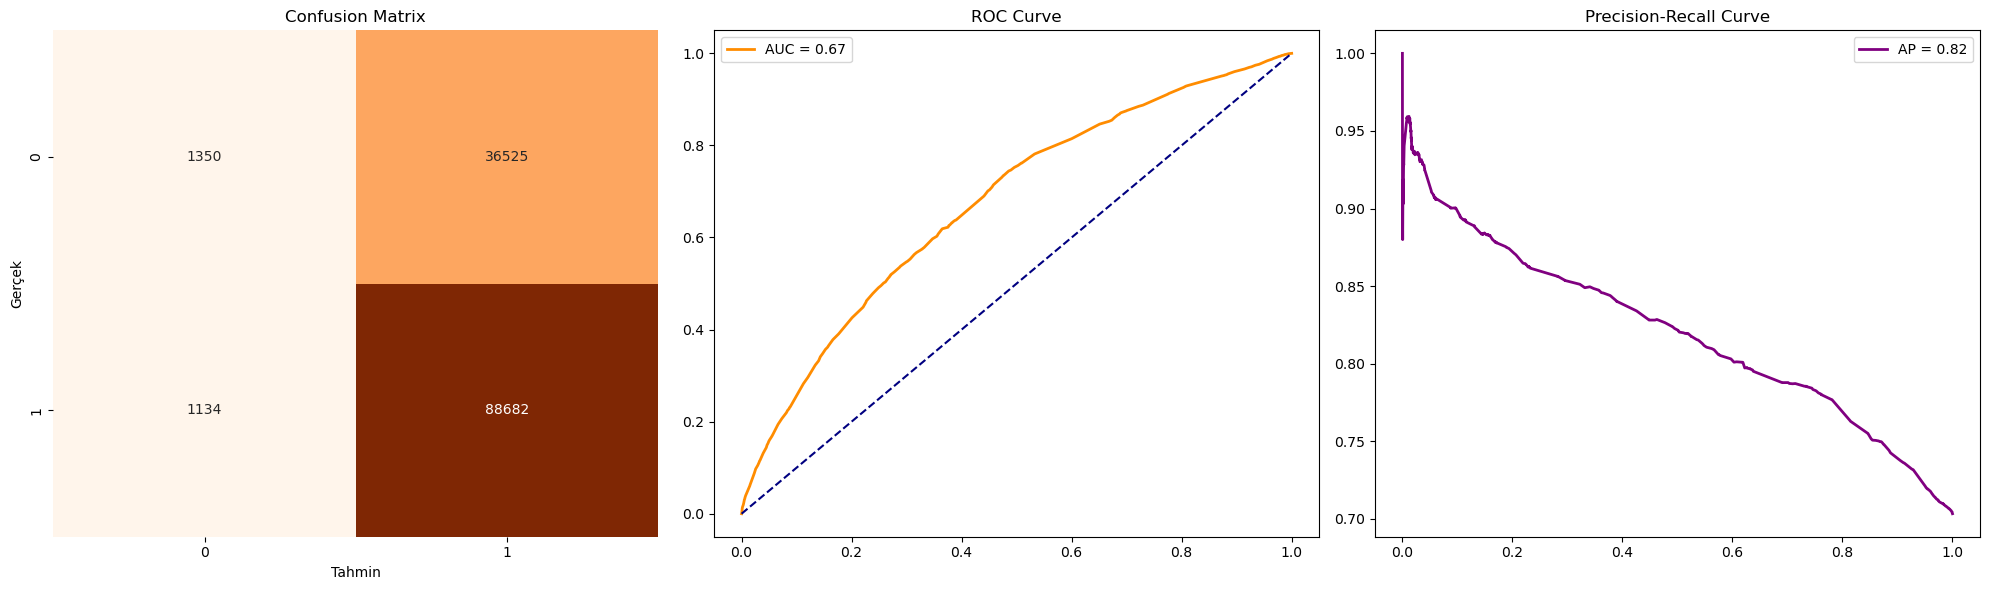

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score, f1_score

import warnings
warnings.filterwarnings('ignore')

print(">>> ADABOOST CLASSIFIER ÇALIŞTIRILIYOR...\n")

# ---------------------------------------------------------
# 1. VERİ HAZIRLIĞI & MÜHENDİSLİK (Standart)
# ---------------------------------------------------------
df = pd.read_csv('US_Crime_DataSet.csv', low_memory=False)

drop_cols = ['Record ID', 'Agency Code', 'Incident', 'Record Source',
             'Victim Ethnicity', 'Victim Count', 'Perpetrator Ethnicity', 'Perpetrator Count',
             'Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race', 'Relationship']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])
df['Crime Solved'] = df['Crime Solved'].map({'Yes': 1, 'No': 0})
df['Victim Age'] = pd.to_numeric(df['Victim Age'], errors='coerce').fillna(30)

# Feature Engineering
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Fall'
df['Season'] = df['Month'].apply(get_season)

bins = [0, 18, 29, 59, 120]
labels = ['Child', 'Young_Adult', 'Adult', 'Senior']
df['Age_Group'] = pd.cut(df['Victim Age'], bins=bins, labels=labels, right=True).astype(object).fillna('Unknown')

regions = {
    'West': ['WA', 'OR', 'CA', 'NV', 'ID', 'MT', 'WY', 'UT', 'AZ', 'NM', 'CO', 'AK', 'HI'],
    'Midwest': ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH'],
    'South': ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'TN', 'KY', 'WV', 'VA', 'NC', 'SC', 'GA', 'FL', 'DE', 'MD', 'DC'],
    'Northeast': ['PA', 'NY', 'NJ', 'CT', 'RI', 'MA', 'VT', 'NH', 'ME']
}
state_to_region = {state: region for region, states in regions.items() for state in states}
df['Region'] = df['State'].map(state_to_region).fillna('Other')

# Encoding
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna('Unknown')
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

X = df.drop('Crime Solved', axis=1)
y = df['Crime Solved']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 2. FEATURE SELECTION
# max_features=10 ile devam ediyoruz
fs = SelectFromModel(DecisionTreeClassifier(max_depth=10, random_state=42), max_features=10)
fs.fit(X_train_raw, y_train)
X_train = fs.transform(X_train_raw)
X_test = fs.transform(X_test_raw)

# ---------------------------------------------------------
# 3. MODEL EĞİTİMİ (ADABOOST)
# ---------------------------------------------------------
print("🚀 AdaBoostClassifier Eğitiliyor...")
start_time = time.time()

# AdaBoost genelde 50-100 estimator ile iyi çalışır
model = AdaBoostClassifier(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

elapsed = time.time() - start_time
print(f"✅ Eğitim Bitti! Süre: {elapsed:.2f} saniye")

# 4. SONUÇLAR
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n" + "="*60)
print("🏆 ADABOOST PERFORMANS RAPORU")
print("="*60)
print(f"1. Accuracy (Doğruluk):  %{acc*100:.2f}")
print(f"2. ROC AUC Skoru:        {roc:.4f}")
print(f"3. F1 Score (Weighted):  {f1:.4f}")
print("-" * 60)
print("DETAYLI SINIFLANDIRMA RAPORU:")
print(classification_report(y_test, y_pred, target_names=['Çözülemedi (0)', 'Çözüldü (1)']))
print("="*60)

# 5. GÖRSELLEŞTİRME
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=axes[0], cbar=False) # AdaBoost turuncuyu sever
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Tahmin')
axes[0].set_ylabel('Gerçek')

fpr, tpr, _ = roc_curve(y_test, y_prob)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc:.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
axes[1].set_title('ROC Curve')
axes[1].legend()

precision, recall, _ = precision_recall_curve(y_test, y_prob)
avg_prec = average_precision_score(y_test, y_prob)
axes[2].plot(recall, precision, color='purple', lw=2, label=f'AP = {avg_prec:.2f}')
axes[2].set_title('Precision-Recall Curve')
axes[2].legend()

plt.tight_layout()
plt.show()